<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/SIG_SUB_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import scipy as sp
from scipy import stats

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
FEATURES = ['VIOLATION_OCCUR_DT', 'MINE_ID', 'MINE_TYPE', 'COAL_METAL_IND', 'SIG_SUB', 
            'INJ_ILLNESS', 'NO_AFFECTED', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT',
            'VIOLATOR_INSPECTION_DAY_CNT']
TARGETS = ['PROPOSED_PENALTY']

In [8]:
path = '/content/gdrive/My Drive/NIOSH Project/data/violations_processed_after_2010.csv'
violation_data = pd.read_csv(path)

print('Samples in dataset: ', len(violation_data))

Samples in dataset:  1429135


In [9]:
significant_data = violation_data[violation_data['SIG_SUB'] == 'Y']
print('Significant and substantial samples in dataset: ', len(significant_data))

Significant and substantial samples in dataset:  342474


## Prepare and Split Significant Data

In [10]:
FEATURES = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 
            'INJ_ILLNESS', 'NO_AFFECTED', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT',
            'VIOLATOR_INSPECTION_DAY_CNT']
TARGETS = ['PROPOSED_PENALTY']

X = significant_data[FEATURES]
y = significant_data[TARGETS]

# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 'INJ_ILLNESS', 'NEGLIGENCE']
columns_to_scale  = ['VIOLATOR_VIOLATION_CNT', 'NO_AFFECTED', 'VIOLATOR_INSPECTION_DAY_CNT']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print('Features shape:', X_pre.shape)

X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Features shape: (342474, 22)
X_train shape: (256855, 22)
X_test shape: (85619, 22)
y_train shape: (256855, 1)
y_train shape: (85619, 1)


## Desicion Tree Model With AdaBoost
Apply hyper parameter tuning using cross-validation and gridsearch.

In [53]:
n_estimators_range = np.arange(2, 11, 2)
max_depth_range = [DecisionTreeRegressor(max_depth=x) for x in range(2, 17, 2)]
hyper_param_grid = dict(estimator=max_depth_range, n_estimators=n_estimators_range)

tree_regressor_adaboost = AdaBoostRegressor()

grid = GridSearchCV(tree_regressor_adaboost, hyper_param_grid, cv=5, return_train_score=False, refit=True, n_jobs=-1)
grid.fit(X_train, y_train.values.ravel())

tree_regressor_adaboost_optimal = grid.best_estimator_

Best r2 Score:  0.4983829609149536
Best Parameters:  {'estimator': DecisionTreeRegressor(max_depth=12), 'n_estimators': 4}


### Cross Validation Results


In [59]:
print('Mean cross-validated r2 score: ', grid.best_score_)
print('Best Parameters: ', grid.best_params_)

Mean cross-validated r2 score:  0.4983829609149536
Best Parameters:  {'estimator': DecisionTreeRegressor(max_depth=12), 'n_estimators': 4}


#### Compute Final Testing Scores

In [54]:
tree_regressor_adaboost_y_pred_train = tree_regressor_adaboost_optimal.predict(X_train)
tree_regressor_adaboost_y_pred_test = tree_regressor_adaboost_optimal.predict(X_test)

tree_regressor_adaboost_r_squared_train = r2_score(y_train, tree_regressor_adaboost_y_pred_train)
tree_regressor_adaboost_r_squared_test = r2_score(y_test, tree_regressor_adaboost_y_pred_test)

tree_regressor_adaboost_mae_train = mean_absolute_error(y_train, tree_regressor_adaboost_y_pred_train)
tree_regressor_adaboost_mae_test = mean_absolute_error(y_test, tree_regressor_adaboost_y_pred_test)

print('Decision Tree Regression with AdaBoost Scores:')
print('Training R^2 = %.3f' % tree_regressor_adaboost_r_squared_train)
print('Training MAE = $%.2f' % tree_regressor_adaboost_mae_train)

print('\nTesting R^2 = %.3f' % tree_regressor_adaboost_r_squared_test)
print('Testing MAE = $%.2f' % tree_regressor_adaboost_mae_test)

Decision Tree Regression with AdaBoost Scores:
Training R^2 = 0.748
Training MAE = $1004.79

Testing R^2 = 0.530
Testing MAE = $1154.12


### Save Final Model

In [55]:
# Save the model
filename = '/content/gdrive/My Drive/SIG_SUB_tree_regressor_adaboost_model_final.joblib'
dump(tree_regressor_adaboost_optimal, filename)

['/content/gdrive/My Drive/SIG_SUB_tree_regressor_adaboost_model_final.joblib']

## Train Neural Network

In [23]:
def scheduler(epoch, lr):
  if epoch < 85:
    return lr
  else: # Drop learning rate after the first 85 epochs
    return lr*np.exp(-0.05)

In [24]:
batch_size = 4096*2
epochs = 120
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = keras.Sequential()

model.add(keras.Input(shape = (len(X_train[0]), ) ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(1, activation="linear"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=opt)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/120
32/32 [==============================] - 2s 25ms/step - loss: 47114180.0000 - val_loss: 48527564.0000 - lr: 0.0100
Epoch 2/120
32/32 [==============================] - 1s 17ms/step - loss: 45972520.0000 - val_loss: 42875732.0000 - lr: 0.0100
Epoch 3/120
32/32 [==============================] - 1s 17ms/step - loss: 38816668.0000 - val_loss: 36564640.0000 - lr: 0.0100
Epoch 4/120
32/32 [==============================] - 1s 18ms/step - loss: 32339162.0000 - val_loss: 30185592.0000 - lr: 0.0100
Epoch 5/120
32/32 [==============================] - 1s 17ms/step - loss: 27099322.0000 - val_loss: 25719076.0000 - lr: 0.0100
Epoch 6/120
32/32 [==============================] - 1s 18ms/step - loss: 24227474.0000 - val_loss: 23186046.0000 - lr: 0.0100
Epoch 7/120
32/32 [==============================] - 1s 17ms/step - loss: 23026070.0000 - val_loss: 23005250.0000 - lr: 0.0100
Epoch 8/120
32/32 [==============================] - 1s 27ms/step - loss: 22680308.0000 - val_loss: 22477556.00

In [27]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('Testing r2 = %.3f' % r2)

2676/2676 [==============================] - 9s 3ms/step
Testing r2 = 0.591


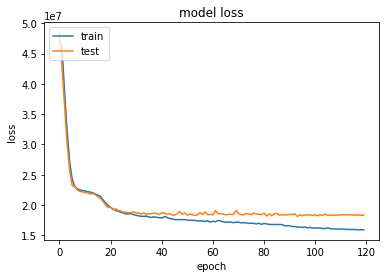

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()